# Udacity MLND Capstone Project: Quora Question Pairs - Kaggle Prediction Competition

Running the Quora Question Pairs Prediction Competition. Details can be found at: https://www.kaggle.com/c/quora-question-pairs

## Importing Data
In this first section, we will import the data, check for any null values and replace them with generic text 'empty'. Lastly, we will print the shape of our training and test datasets.

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from __future__ import print_function, division
%matplotlib inline

pal = sns.color_palette()

# Input data files are available in the "input/" directory.
train_df = pd.read_csv("input/train.csv")
test_df = pd.read_csv("input/test.csv")

#Checking to see if there are any null values in the dataset
print('There are %d null values in the training dataset, and %d null values in the test dataset.' % (train_df.isnull().sum().sum(), test_df.isnull().sum().sum()))

#if desired, review the null values in the dataset
#print(train_df[pd.isnull(train_df).any(axis=1)])
#print(test_df[pd.isnull(test_df).any(axis=1)])

#set null values to generic text 'empty'
train_df.ix[train_df['question1'].isnull(),['question1']] = 'empty'
train_df.ix[train_df['question2'].isnull(),['question2']] = 'empty'
test_df.ix[test_df['question1'].isnull(),['question1']] = 'empty'
test_df.ix[test_df['question2'].isnull(),['question2']] = 'empty'
print("Null values have been replaced with generic text: 'empty'")

#confirm null values set correctly
#print(train_df.loc[train_df['question1'] == 'empty'])
#print(train_df.loc[train_df['question2'] == 'empty'])
#print(test_df.loc[test_df['question1'] == 'empty'])
#print(test_df.loc[test_df['question2'] == 'empty'])

print(train_df.shape)
print(test_df.shape)

There are 2 null values in the training dataset, and 6 null values in the test dataset.
Null values have been replaced with generic text: 'empty'
(404290, 6)
(2345796, 3)


## Data Exploration
Next, we will view samples of the first 5 records from each of our dataframes, **train_df** and **test_df**.

In [2]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [4]:
# Review the number of duplicate question pairs in the training dataset
is_dup = train_df['is_duplicate'].value_counts()

print("Number of Duplicate Records in Training Dataset: ")
print(is_dup)

print("\nPercentage of Duplicate Records in Training Dataset: ")
print(is_dup / is_dup.sum())

Number of Duplicate Records in Training Dataset: 
0    255027
1    149263
Name: is_duplicate, dtype: int64

Percentage of Duplicate Records in Training Dataset: 
0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64


From above, we can see that there are 149,263 (63.08%) duplicate question pairs in the training dataset, and 255,027 question pairs (36.92%) which are not duplicate.

### Identifying Duplicate Individual Questions
The next step we will do in our data exploration is review how many duplicate individual questions there are across our training dataset. 

Total number of question pairs in the training set: 404290
Duplicate pairs: 36.92%
Total number of unique questions (across both qid1 and qid2) in the training data: 537933
Number of Questions that Appear Multiple Times: 111780



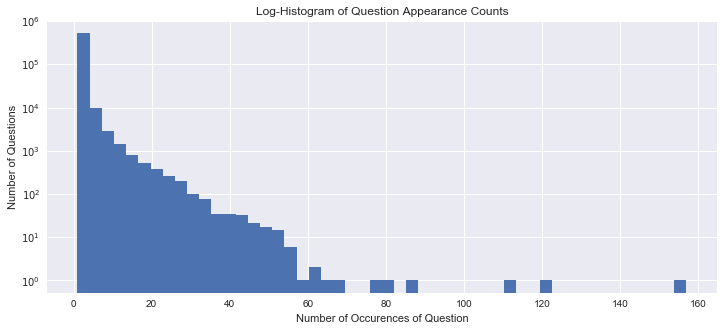

In [5]:
print("Total number of question pairs in the training set: {}".format(len(train_df)))
print('Duplicate pairs: {}%'.format(round(train_df['is_duplicate'].mean()*100, 2)))
qids = pd.Series(train_df['qid1'].tolist() + train_df['qid2'].tolist())
print('Total number of unique questions (across both qid1 and qid2) in the training data: {}'.format(len(
    np.unique(qids))))
print('Number of Questions that Appear Multiple Times: {}'.format(np.sum(qids.value_counts() > 1)))

#Print the Log-Histogram of Question Appearance Counts in our Training Data. 
plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of Question Appearance Counts')
plt.xlabel('Number of Occurences of Question')
plt.ylabel('Number of Questions')
print()

**The vast majority of questions either appear once or a few times.** It's possible Quora could have provided every possible unique combination of question (each question compared to every other question) but that would have generated a huge amount of data, and it would be very clear in the majority of cases that questions were not duplicates.

**There is a very small number of questions appearing up to around ~50 times, and three questions that appear over 100 times (111, 120, and 157 times each).** These three questions appear to be outliers.

## Data Preprocessing
In this section we will remove stop words and punctuation from question1 and question2 in train_df and test_df, and save copies of these two datafames as train_df_clean, and test_df_clean.

In [7]:
#from nltk.corpus import stopwords
#stops = set(stopwords.words("english"))

#define custom stop words list
stops = ['the','a','an','and','but','if','or','because','as','what','which','this','that','these','those','then',
              'just','so','than','such','both','through','about','for','is','of','while','during','to','What','Which',
              'Is','If','While','This']

In [10]:
from string import punctuation
import re
from nltk.stem import PorterStemmer
stemmer=PorterStemmer()

def text_to_wordlist(text, remove_punctuation=True, remove_stop_words=True, porter_stemmer=True):
    # Remove punctuation and stop words

    # Remove punctuation
    if remove_punctuation:
        text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    
    # Optionally, remove stop words
    if remove_stop_words:
        text = text.split()
        text = [w for w in text if not w in stops]
        text = " ".join(text)
        
    # Optionally, use porter stemmer
    # Note, I'm also lowering the text here...
    if porter_stemmer:
        text = " ".join([stemmer.stem(kw) for kw in text.lower().split(" ")])
    
    if text == '':
        text = 'empty'
        #print("text empty")
    
    return text

In [11]:
def process_questions(question_list, questions, question_list_name, dataframe):
    '''transform questions and display progress'''
    for question in questions:
        question_list.append(text_to_wordlist(question))
        
        #print out the progress of processing questions each 100000 processed
        if len(question_list) % 250000 == 0:
            progress = len(question_list)/len(dataframe) * 100
            print("{} is {}% complete.".format(question_list_name, round(progress, 1)))

In [12]:
#process training question1 and question2 to remove punctuation and/or stop words
train_question1 = []
process_questions(train_question1, train_df.question1, 'train_question1', train_df)

train_question2 = []
process_questions(train_question2, train_df.question2.astype(str), 'train_question2', train_df)

train_question1 is 61.8% complete.
train_question2 is 61.8% complete.


In [16]:
#process test dataset question1 and question2 to remove punctuation and/or stop words
test_question1 = []
process_questions(test_question1, test_df.question1.astype(str), 'test_question1', test_df)
test_question2 = []
process_questions(test_question2, test_df.question2.astype(str), 'test_question2', test_df)

test_question1 is 10.7% complete.
test_question1 is 21.3% complete.
test_question1 is 32.0% complete.
test_question1 is 42.6% complete.
test_question1 is 53.3% complete.
test_question1 is 63.9% complete.
test_question1 is 74.6% complete.
test_question1 is 85.3% complete.
test_question1 is 95.9% complete.
test_question2 is 10.7% complete.
test_question2 is 21.3% complete.
test_question2 is 32.0% complete.
test_question2 is 42.6% complete.
test_question2 is 53.3% complete.
test_question2 is 63.9% complete.
test_question2 is 74.6% complete.
test_question2 is 85.3% complete.
test_question2 is 95.9% complete.


In [41]:
# review the results of the data preprocessing steps
a=0
for i in range(a,a+2):
    print(train_question1[i])
    print(train_df['question1'][i])
    print(train_question2[i])
    print(train_df['question2'][i])
    print()

step by step guid invest in share market in india
What is the step by step guide to invest in share market in india?
step by step guid invest in share market
What is the step by step guide to invest in share market?

stori kohinoor koh-i-noor diamond
What is the story of Kohinoor (Koh-i-Noor) Diamond?
would happen indian govern stole kohinoor koh-i-noor diamond back
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?



In [42]:
#create separate training and test datasets that have been cleaned.
train_df_clean = pd.DataFrame()
test_df_clean = pd.DataFrame()
train_df_clean = train_df.copy()
test_df_clean = test_df.copy()

train_df_clean['question1'] = train_question1
train_df_clean['question2'] = train_question2
test_df_clean['question1'] = test_question1
test_df_clean['question2'] = test_question2

In [22]:
#Saving our cleaned dataframes to disk for easy retrieval
train_df_clean.to_csv("input/train_df_clean.csv", sep="\t")
test_df_clean.to_csv("input/test_df_clean.csv", sep="\t")

## Checkpoint 1:  Jump here to retrieve cleaned dataframes from disk.

In [6]:
# Retrieve our cleaned dataframe files from disk if desired
train_df_clean = pd.read_csv("input/train_df_clean.csv", sep='\t')
test_df_clean = pd.read_csv("input/test_df_clean.csv", sep='\t')

# Print out the columns of the loaded dataframes
print(train_df_clean.columns.values)
print(test_df_clean.columns.values)

# Drop the unnamed column
train_df_clean = train_df_clean.drop('Unnamed: 0', 1)
test_df_clean = test_df_clean.drop('Unnamed: 0', 1)
print("Columns 'Unnamed: 0' dropped.")

# Print out the shape for confirmation
print(train_df_clean.shape)
print(test_df_clean.shape)

['Unnamed: 0' 'id' 'qid1' 'qid2' 'question1' 'question2' 'is_duplicate']
['Unnamed: 0' 'test_id' 'question1' 'question2']
Columns 'Unnamed: 0' dropped.
(404290, 6)
(2345796, 3)


## Feature Engineering

In [75]:
#Reset the data preprocessing and determine whether or not to proceed with cleaned dataframes or the original
proceed_with_clean_words= False

if proceed_with_clean_words:
    train_df_x = train_df_clean
    test_df_x = test_df_clean
else:
    train_df_x = train_df
    test_df_x = test_df 
    
print(train_df_x.head(n=1))
print(test_df_x.head(n=1))

   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
   test_id                                          question1  \
0        0  How does the Surface Pro himself 4 compare wit...   

                                           question2  
0  Why did Microsoft choose core m3 and not core ...  


### Word Match Sharing
In this section we will calculate the percentage of words that are shared between the two question pairs, and review the distributions across our training set where the questions are duplicate and where the are not. 

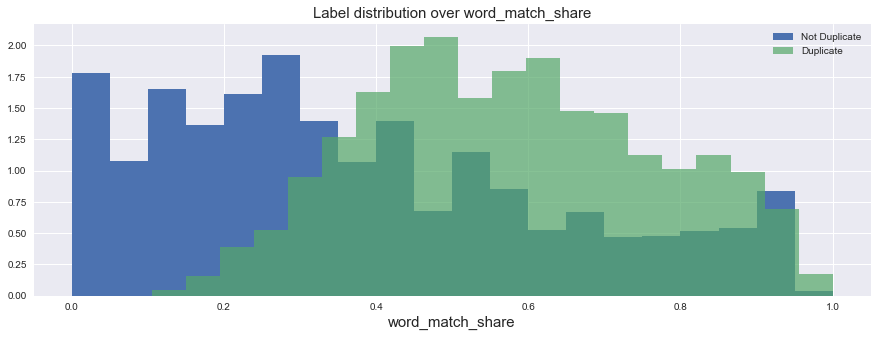

In [76]:
def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # Several questions include only stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = float((len(shared_words_in_q1) + len(shared_words_in_q2)))/float((len(q1words) + len(q2words)))
    return R

plt.figure(figsize=(15, 5))
train_word_match = train_df_x.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[train_df_x['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[train_df_x['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

From this Distribution chart we can see that the remaining shared words does have a certain amount of predictive power in terms of whether two questions are duplicate or not. In particular, the vast majority of question pairs with a score of less than .2 in this word share distribution are all 'Not Duplicate'.  However it's not so great at separating out the Duplicates. For those Question Pairs above .4 we see that there are approximately twice as many Duplicate question pairs as compared to Not Duplicates yet there still is substantial overlap.

## Levenshtein Ratio
Calculating Levenstein ratio over the two strings and visualizing the results.

In [77]:
import Levenshtein as lev

t = []
for r in zip(train_df_x['question1'].astype(str), train_df_x['question2'].astype(str)):
    t.append(lev.ratio(r[0], r[1]))
train_df_x['lev_ratio'] = t

t = []
for r in zip(test_df_x['question1'].astype(str), test_df_x['question2'].astype(str)):
    t.append(lev.ratio(r[0], r[1]))
test_df_x['lev_ratio'] = t

del t

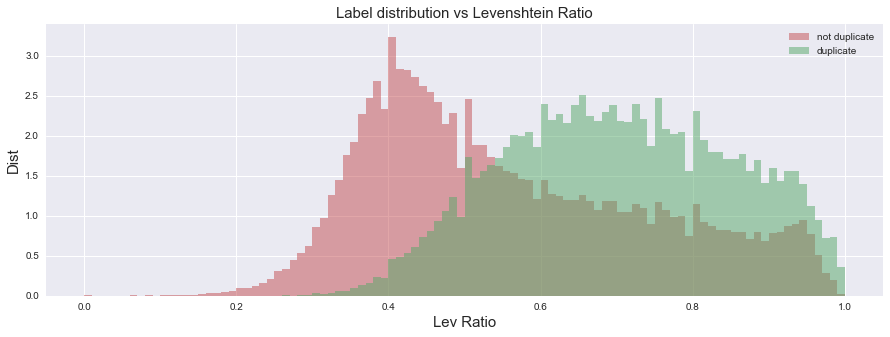

In [78]:
plt.figure(figsize=(15, 5))
plt.hist(train_df_x[train_df_x['is_duplicate']== 0]['lev_ratio'], bins=100, range=[0, 1], color=pal[2], normed=True, alpha=0.5, label='not duplicate')
plt.hist(train_df_x[train_df_x['is_duplicate']== 1]['lev_ratio'], bins=100, range=[0, 1], color=pal[1], normed=True, alpha=0.5, label='duplicate')
plt.title('Label distribution over Levenshtein Ratio', fontsize=15)
plt.legend()
plt.xlabel('Lev Ratio', fontsize=15)
plt.ylabel('Distribution', fontsize=15)

## Calculating Cosine Similarity using TfidfVectorizer

In [79]:
# put all our training questions in a single list and all testing questions in a single list.
train_q = pd.Series(train_df_x['question1'].tolist() + train_df_x['question2'].tolist()).astype(str)
test_q = pd.Series(test_df_x['question1'].tolist() + test_df_x['question2'].tolist()).astype(str)

In [140]:
tfidfstart = time.time()

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df = 2)
#tfidf_matrix = tfidf_vectorizer.fit_transform(train_q)

#fit the TfidfVectorizer to text present in questions 1 and 2.
tfidf_matrix = tfidf_vectorizer.fit(pd.concat((train_df_x.ix[:,'question1'],train_df_x.ix[:,'question2'])).unique())

#transform to generate the vectors for each question
trainQuestion1_tfs = tfidf_vectorizer.transform(train_df_x.ix[:,'question1'])
trainQuestion2_tfs = tfidf_vectorizer.transform(train_df_x.ix[:,'question2'])

print("Training Question 1 Shape: ", trainQuestion1_tfs.shape)
print("Training Question 2 Shape: ", trainQuestion2_tfs.shape)

tfidf_complete = (time.time() - tfidfstart)/60.0
print("TF-IDF Fit Transform time took %.2f minutes" % (tfidf_complete))

Training Question 1 Shape:  (404290, 47302)
Training Question 2 Shape:  (404290, 47302)
TF-IDF Fit Transform time took 0.42 minutes


In [141]:
from sklearn.metrics.pairwise import cosine_similarity
start_train2 = time.time()

cos_sim_train = []
for x in range(0,404290):
    cos_sim_train.append((cosine_similarity(trainQuestion1_tfs[x],trainQuestion2_tfs[x]))[0][0])
    x = x+1
    
    #print out the progress of processing cosine similarity each 100000 processed
    if x % 100000 == 0:
        progress = x/404290.0 * 100
        print("Cosine Similarity is {}% complete.".format(round(progress, 1)))

#print(cos_sim_train)

complete_train1 = (time.time() - start_train2)/60.0
print("TF-IDF Fit Transform time took %.2f minutes" % (complete_train1))

Cosine Similarity is 24.7% complete.
Cosine Similarity is 49.5% complete.
Cosine Similarity is 74.2% complete.
Cosine Similarity is 98.9% complete.
TF-IDF Fit Transform time took 6.01 minutes


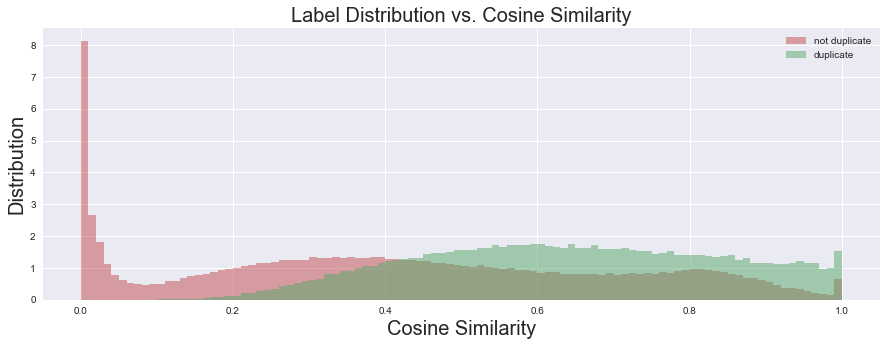

In [142]:
train_df_x['cos_sim'] = cos_sim_train

#Label distribution vs Cosine Similarity
plt.figure(figsize=(15, 5))
plt.hist(train_df_x[train_df_x['is_duplicate']== 0]['cos_sim'], bins=100, range=[0, 1], color=pal[2], normed=True, alpha=0.5, label='not duplicate')
plt.hist(train_df_x[train_df_x['is_duplicate']== 1]['cos_sim'], bins=100, range=[0, 1], color=pal[1], normed=True, alpha=0.5, label='duplicate')
plt.title('Label Distribution vs. Cosine Similarity', fontsize=20)
plt.legend()
plt.xlabel('Cosine Similarity', fontsize=20)
plt.ylabel('Distribution', fontsize=20)

In [143]:
#Transform Test values
tfidfstart_test1 = time.time()

testQuestion1_tfs = tfidf_vectorizer.transform(test_df_x.ix[:,'question1'])
testQuestion2_tfs = tfidf_vectorizer.transform(test_df_x.ix[:,'question2'])
print("Test Question 1 Shape: ", testQuestion1_tfs.shape)
print("Test Question 2 Shape: ", testQuestion2_tfs.shape)

tfidf_complete_test1 = (time.time() - tfidfstart_test1)/60.0
print("TF-IDF Transform time on Test set took %.2f minutes" % (tfidf_complete_test1))

Test Question 1 Shape:  (2345796, 47302)
Test Question 2 Shape:  (2345796, 47302)
TF-IDF Transform time on Test set took 1.60 minutes


In [144]:
#Get Cosine Similarity values for test set
tfidfstart_test2 = time.time()

x = 0
cos_sim_test = []        
for x in range(0,2345796):
    cos_sim_test.append((cosine_similarity(testQuestion1_tfs[x],testQuestion2_tfs[x]))[0][0])
    x = x+1
    
    #print out the progress of processing cosine similarity each 100000 processed
    if x % 250000 == 0:
        progress = x/2345796.0 * 100
        print("Cosine Similarity is {}% complete.".format(round(progress, 1)))        
        
# print out length of the list for validation.
print(len(cos_sim_test))

tfidf_complete_test2 = (time.time() - tfidfstart_test2)/60.0
print("Generating Cosine Sim. Values on Test set took %.2f minutes" % (tfidf_complete_test2))

Cosine Similarity is 10.7% complete.
Cosine Similarity is 21.3% complete.
Cosine Similarity is 32.0% complete.
Cosine Similarity is 42.6% complete.
Cosine Similarity is 53.3% complete.
Cosine Similarity is 63.9% complete.
Cosine Similarity is 74.6% complete.
Cosine Similarity is 85.3% complete.
Cosine Similarity is 95.9% complete.
2345796
Generating Cosine Sim. Values on Test set took 33.44 minutes


In [154]:
# First we create our training and testing data
x_train = pd.DataFrame()
x_test = pd.DataFrame()
x_train['word_match'] = train_word_match
#x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = test_df_x.apply(word_match_share, axis=1, raw=True)
#x_test['tfidf_word_match'] = test_df.apply(tfidf_word_match_share, axis=1, raw=True)

# adding word_delta & char_delta variables
#x_train['word_delta'] = train_df['word_delta']
#x_train['char_delta'] = train_df['char_delta']
#x_test['word_delta'] = test_df['word_delta']
#x_test['char_delta'] = test_df['char_delta']

# adding levenshtein ratios
x_train['lev_ratio'] = train_df_x['lev_ratio']
x_test['lev_ratio'] = test_df_x['lev_ratio']

# adding tf-idf cosine similarity scores
x_train['cos_sim'] = cos_sim_train
x_test['cos_sim'] = cos_sim_test


y_train = train_df_x['is_duplicate'].values

## Rebalancing the Data
This section was taken from: https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb

In [155]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.191243661001


In [156]:
# Finally, we split some of the data off for validation
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

## Benchmark Random Forests

In [158]:
from sklearn.model_selection import GridSearchCV
from sklearn.encajuisemble import RandomForestClassifier
from sklearn.metrics import log_loss 

#parameters_rf = {'n_estimators':[10, 50, 100, 200, 300], 'random_state':[0]}
parameters_rf = {'n_estimators':[10], 'random_state':[0]}

In [159]:
rand_forest_clf = RandomForestClassifier()
cv_rf = GridSearchCV(rand_forest_clf, parameters_rf)

#rand_forest_clf = RandomForestClassifier(n_estimators=200, random_state=0)
cv_rf = cv_rf.fit(x_train, y_train)
print("Best estimator: ", cv_rf.best_estimator_)

Best estimator:  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)


In [160]:
rand_forest_y_pred = cv_rf.predict_proba(x_valid)
rand_forest_y_pred = rand_forest_y_pred[:,1]

log_loss(y_valid, rand_forest_y_pred) 

0.75660028056316053

In [110]:
rand_forest_x_test = cv_rf.predict_proba(x_test)
rand_forest_x_test = rand_forest_x_test[:,1]

### Save the random forest prediction output

In [111]:
sub = pd.DataFrame()
sub['test_id'] = test_df['test_id']
sub['is_duplicate'] = rand_forest_x_test
sub.to_csv('random_forest_23-may-2017.csv', index=False)

## Logistic Regression

In [91]:
from sklearn.linear_model import LogisticRegression

#parameters_lr = {'solver':['sag'], 'C':[.0011, 0.001, 0.0009], 'random_state':[0]}
parameters_lr = {'solver':['sag'], 'C':[.0011], 'random_state':[0]}

In [92]:

logreg = LogisticRegression()
cv_lr = GridSearchCV(logreg, parameters_lr)
#logreg = LogisticRegression(C=1, random_state=0)
cv_lr = cv_lr.fit(x_train, y_train)
print("Best estimator: ", cv_lr.best_estimator_)

Best estimator:  LogisticRegression(C=0.0011, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='sag', tol=0.0001, verbose=0, warm_start=False)


In [93]:
logreg_y_pred = cv_lr.predict_proba(x_valid)
logreg_y_pred = logreg_y_pred[:,1]

log_loss(y_valid, logreg_y_pred) 

0.43963457923139593

In [115]:
#Create predictions for the test dataset
logreg_x_test = cv_lr.predict_proba(x_test)
logreg_x_test = logreg_x_test[:,1]

### Save the logistic regression prediction output

In [116]:
sub = pd.DataFrame()
sub['test_id'] = test_df['test_id']
sub['is_duplicate'] = logreg_x_test
sub.to_csv('logreg_23-may-2017.csv', index=False)

## XGBoost
Now we can finally run XGBoost on our data, in order to see the score on the leaderboard!

In [157]:
import xgboost as xgb

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.3
params['max_depth'] = 8
#params['min_child_weight'] = 1
#params['gamma'] = 0.01
#params['subsample'] = 0.8
#params['colsample_bytree'] = 0.8
#params['scale_pos_weight'] = 1

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.567585	valid-logloss:0.5683
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.381051	valid-logloss:0.384644
[20]	train-logloss:0.375008	valid-logloss:0.379587
[30]	train-logloss:0.372641	valid-logloss:0.378073
[40]	train-logloss:0.370106	valid-logloss:0.376857
[50]	train-logloss:0.368095	valid-logloss:0.376163
[60]	train-logloss:0.366605	valid-logloss:0.375688
[70]	train-logloss:0.365025	valid-logloss:0.375311
[80]	train-logloss:0.363254	valid-logloss:0.37469
[90]	train-logloss:0.361898	valid-logloss:0.374167
[100]	train-logloss:0.360691	valid-logloss:0.37384
[110]	train-logloss:0.359489	valid-logloss:0.373585
[120]	train-logloss:0.358006	valid-logloss:0.37327
[130]	train-logloss:0.356138	valid-logloss:0.372836
[140]	train-logloss:0.354772	valid-logloss:0.372503
[150]	train-logloss:0.353647	valid-logloss:0.372276
[160]	train-logloss:0.352303	vali

In [133]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

In [134]:
sub = pd.DataFrame()
sub['test_id'] = test_df['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('xgb_23-may-2017.csv', index=False)

In [120]:
sub.head()

,test_id,is_duplicate
0,0,0.095496
1,1,0.164058
2,2,0.209786
3,3,0.063417
4,4,0.292574
